# Imports

In [1]:
from cytoflow import *
import os

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture

mpl.rcParams["font.sans-serif"] = "Helvetica"
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["pdf.fonttype"] = 42
sns.set_style(
    "ticks",
    {
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "font_color": "k",
        "axes.edgecolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)
sns.set_context("talk", font_scale=1.0)

# Read in activation, round 1

In [2]:
r1 = pd.read_csv("./data/20211115/all_cells_live_mch_gated.csv")
r1["date"] = ["2021/11/15" for i in list(r1["plasmid"])]
r1 = r1[r1["P1"] & r1["mCherry"]]
r1 = r1[r1["treatment"] == "none"]
r1 = r1[r1["plasmid"] > 71]

# switch 126 to 1260, 217 to 2170, 144 to 1440
def switch_plasmid_num(n):
    return 10 * n if n in [126, 217, 144] else n


r1["plasmid"] = [switch_plasmid_num(n) for n in list(r1["plasmid"])]
r1 = r1.drop("treatment", axis="columns")
r1 = r1[r1["dox"] == 1000]
r1 = r1.drop("dox", axis="columns")
r1

,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry,date
1437385,687454976.0,253626624.0,0.0,Rand Ctrl + Rand Ctrl 89,164999424.0,1902592.0,72,1.0,True,True,2021/11/15
1437386,841019392.0,374519040.0,0.0,Rand Ctrl + Rand Ctrl 89,609591040.0,3906816.0,72,1.0,True,True,2021/11/15
1437387,626120960.0,195277568.0,0.0,Rand Ctrl + Rand Ctrl 89,14574336.0,1753600.0,72,1.0,True,True,2021/11/15
1437388,620810496.0,291401216.0,0.0,Rand Ctrl + Rand Ctrl 89,25415424.0,2119424.0,72,1.0,True,True,2021/11/15
1437389,541283328.0,205639168.0,0.0,Rand Ctrl + Rand Ctrl 89,20121088.0,1982976.0,72,1.0,True,True,2021/11/15
...,...,...,...,...,...,...,...,...,...,...,...
3151328,601281024.0,133874688.0,2.0,MYB only,176326656.0,55230720.0,1440,2.0,True,True,2021/11/15
3151329,695473664.0,131379968.0,2.0,MYB only,31460352.0,150414848.0,1440,2.0,True,True,2021/11/15
3151330,496356096.0,105681920.0,2.0,MYB only,79604736.0,31723008.0,1440,2.0,True,True,2021/11/15
3151331,731016448.0,142353920.0,2.0,MYB only,159009792.0,2278656.0,1440,2.0,True,True,2021/11/15


# Read in activation, round 2

In [3]:
r2 = pd.read_csv("./data/20220303/all_cells_live_mch_gated.csv")
r2["date"] = ["2022/03/03" for i in list(r2["plasmid"])]
r2 = r2[r2["P1"] & r2["mCherry"]]

r2

,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry,date
0,357657344.0,130077184.0,0.0,rTetR only,214476800.0,935936.0,1260,1.0,True,True,2022/03/03
1,613253888.0,186921472.0,0.0,rTetR only,88771328.0,1988608.0,1260,1.0,True,True,2022/03/03
2,409882368.0,184542208.0,0.0,rTetR only,340477184.0,2286848.0,1260,1.0,True,True,2022/03/03
3,438074880.0,229615616.0,0.0,rTetR only,140216320.0,2050560.0,1260,1.0,True,True,2022/03/03
4,550200064.0,295275008.0,0.0,rTetR only,163602944.0,2893824.0,1260,1.0,True,True,2022/03/03
...,...,...,...,...,...,...,...,...,...,...,...
1685738,518283520.0,158495488.0,2.0,NOTC2 - Ctrl,98124544.0,1948672.0,157,2.0,True,True,2022/03/03
1685739,722553088.0,150331904.0,2.0,NOTC2 - Ctrl,40823296.0,2093056.0,157,2.0,True,True,2022/03/03
1685740,759366144.0,261527296.0,2.0,NOTC2 - Ctrl,191577600.0,2949632.0,157,2.0,True,True,2022/03/03
1685741,552823296.0,149416960.0,2.0,NOTC2 - Ctrl,106409984.0,2251008.0,157,2.0,True,True,2022/03/03


In [4]:
df = pd.concat([r1, r2]).reset_index()
df

,index,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry,date
0,1437385,687454976.0,253626624.0,0.0,Rand Ctrl + Rand Ctrl 89,164999424.0,1902592.0,72,1.0,True,True,2021/11/15
1,1437386,841019392.0,374519040.0,0.0,Rand Ctrl + Rand Ctrl 89,609591040.0,3906816.0,72,1.0,True,True,2021/11/15
2,1437387,626120960.0,195277568.0,0.0,Rand Ctrl + Rand Ctrl 89,14574336.0,1753600.0,72,1.0,True,True,2021/11/15
3,1437388,620810496.0,291401216.0,0.0,Rand Ctrl + Rand Ctrl 89,25415424.0,2119424.0,72,1.0,True,True,2021/11/15
4,1437389,541283328.0,205639168.0,0.0,Rand Ctrl + Rand Ctrl 89,20121088.0,1982976.0,72,1.0,True,True,2021/11/15
...,...,...,...,...,...,...,...,...,...,...,...,...
2253290,1685738,518283520.0,158495488.0,2.0,NOTC2 - Ctrl,98124544.0,1948672.0,157,2.0,True,True,2022/03/03
2253291,1685739,722553088.0,150331904.0,2.0,NOTC2 - Ctrl,40823296.0,2093056.0,157,2.0,True,True,2022/03/03
2253292,1685740,759366144.0,261527296.0,2.0,NOTC2 - Ctrl,191577600.0,2949632.0,157,2.0,True,True,2022/03/03
2253293,1685741,552823296.0,149416960.0,2.0,NOTC2 - Ctrl,106409984.0,2251008.0,157,2.0,True,True,2022/03/03


# Draw citrine thresholds

In [5]:
def get_citrine_threshold(day, date):
    # return mean + 2 SDs of pJT126
    data = df[df["date"] == date]
    data = data[data["day"] == day]
    data = data[data["plasmid"] == 1260]
    return np.mean(data["mCitrine-A"]) + 4 * np.std(data["mCitrine-A"])

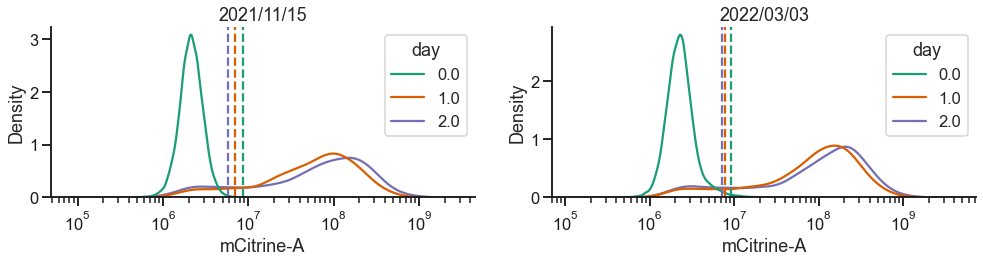

In [6]:
dates = sorted(list(set(list(df["date"]))))

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

for i, d in enumerate(dates):
    a = ax[i]
    cd = df[df["date"] == d]
    cd = cd[cd["plasmid"] == 1440]
    sns.kdeplot(
        data=cd,
        x="mCitrine-A",
        hue="day",
        palette="Dark2",
        common_norm=False,
        log_scale=True,
        ax=a,
    )
    a.set_title(d)
    pal = sns.color_palette("Dark2")
    daylist = [0, 1, 2]
    for j, day in enumerate(daylist):
        a.axvline(get_citrine_threshold(day, d), color=pal[j], linestyle="--")

sns.despine(fig)
plt.tight_layout()

In [7]:
days = [0, 1, 2]
dates = sorted(list(set(list(df["date"]))))

dd_thresh_dict = {
    date: {day: get_citrine_threshold(day, date) for day in days} for date in dates
}

df["Citrine On"] = [
    c >= dd_thresh_dict[t][d]
    for c, d, t in tqdm(
        zip(list(df["mCitrine-A"]), list(df["day"]), list(df["date"])),
        total=len(list(df["day"])),
    )
]
df

  0%|          | 0/2253295 [00:00<?, ?it/s]

,index,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate,P1,mCherry,date,Citrine On
0,1437385,687454976.0,253626624.0,0.0,Rand Ctrl + Rand Ctrl 89,164999424.0,1902592.0,72,1.0,True,True,2021/11/15,False
1,1437386,841019392.0,374519040.0,0.0,Rand Ctrl + Rand Ctrl 89,609591040.0,3906816.0,72,1.0,True,True,2021/11/15,False
2,1437387,626120960.0,195277568.0,0.0,Rand Ctrl + Rand Ctrl 89,14574336.0,1753600.0,72,1.0,True,True,2021/11/15,False
3,1437388,620810496.0,291401216.0,0.0,Rand Ctrl + Rand Ctrl 89,25415424.0,2119424.0,72,1.0,True,True,2021/11/15,False
4,1437389,541283328.0,205639168.0,0.0,Rand Ctrl + Rand Ctrl 89,20121088.0,1982976.0,72,1.0,True,True,2021/11/15,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253290,1685738,518283520.0,158495488.0,2.0,NOTC2 - Ctrl,98124544.0,1948672.0,157,2.0,True,True,2022/03/03,False
2253291,1685739,722553088.0,150331904.0,2.0,NOTC2 - Ctrl,40823296.0,2093056.0,157,2.0,True,True,2022/03/03,False
2253292,1685740,759366144.0,261527296.0,2.0,NOTC2 - Ctrl,191577600.0,2949632.0,157,2.0,True,True,2022/03/03,False
2253293,1685741,552823296.0,149416960.0,2.0,NOTC2 - Ctrl,106409984.0,2251008.0,157,2.0,True,True,2022/03/03,False


In [8]:
gdf = df.groupby(['date', 'day', 'plasmid', 'description', 'replicate']).mean().reset_index()
gdf

,date,day,plasmid,description,replicate,index,FSC 488/10-A,SSC 488/10-A,mCherry-A,mCitrine-A,P1,mCherry,Citrine On
0,2021/11/15,0.0,72,Rand Ctrl + Rand Ctrl 89,1.0,1.441098e+06,7.432748e+08,2.766560e+08,1.665374e+08,2.267750e+06,1.0,1.0,0.000755
1,2021/11/15,0.0,72,Rand Ctrl + Rand Ctrl 89,2.0,1.451613e+06,7.554392e+08,2.719777e+08,2.223013e+08,2.266961e+06,1.0,1.0,0.016481
2,2021/11/15,0.0,74,DMD - DMD,1.0,1.465569e+06,7.487829e+08,2.624635e+08,2.359572e+08,2.248402e+06,1.0,1.0,0.000291
3,2021/11/15,0.0,74,DMD - DMD,2.0,1.477666e+06,7.607374e+08,2.537070e+08,2.751042e+08,2.204398e+06,1.0,1.0,0.000781
4,2021/11/15,0.0,75,DMD - RANDCTRL,1.0,1.488782e+06,7.384105e+08,2.483225e+08,1.839675e+08,2.369572e+06,1.0,1.0,0.001901
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2022/03/03,2.0,157,NOTC2 - Ctrl,2.0,1.680792e+06,6.881471e+08,2.002202e+08,2.884211e+08,2.296560e+06,1.0,1.0,0.001797
289,2022/03/03,2.0,1260,rTetR only,1.0,1.220373e+06,7.059353e+08,2.044895e+08,2.602560e+08,2.355131e+06,1.0,1.0,0.008466
290,2022/03/03,2.0,1260,rTetR only,2.0,1.230178e+06,6.693760e+08,2.038422e+08,2.892280e+08,2.360172e+06,1.0,1.0,0.008504
291,2022/03/03,2.0,1440,MYBA only,1.0,1.258769e+06,6.859094e+08,1.921795e+08,1.811240e+08,1.716661e+08,1.0,1.0,0.877969


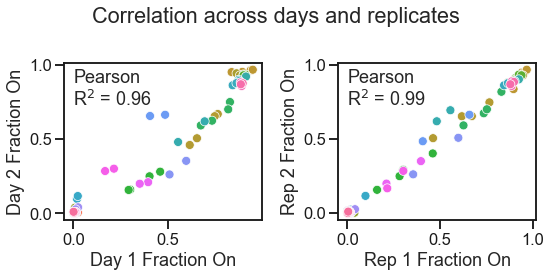

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
pivdf = gdf.pivot(
    index=["plasmid", "description", "replicate", "date"],
    columns="day",
    values="Citrine On",
).reset_index()
corrdf = pivdf.dropna()
g = sns.scatterplot(data=pivdf, x=1.0, y=2.0, hue="description", legend=False, ax=ax)
ax.set_xlabel("Day 1 Fraction On")
ax.set_ylabel("Day 2 Fraction On")
ax.text(
    0,
    0.725,
    "Pearson\nR$^2$ = {:.2f}".format(st.pearsonr(corrdf[1.0], corrdf[2.0])[0] ** 2),
)

ax = axes[1]
pivdf = gdf.pivot(
    index=["plasmid", "description", "day", "date"],
    columns="replicate",
    values="Citrine On",
).reset_index()
corrdf = pivdf.dropna()
g = sns.scatterplot(data=pivdf, x=1.0, y=2.0, hue="description", legend=False, ax=ax)
ax.set_xlabel("Rep 1 Fraction On")
ax.set_ylabel("Rep 2 Fraction On")
ax.text(
    0,
    0.725,
    "Pearson\nR$^2$ = {:.2f}".format(st.pearsonr(corrdf[1.0], corrdf[2.0])[0] ** 2),
)

fig.suptitle("Correlation across days and replicates")
plt.tight_layout()

fig.savefig("./act_correlations.pdf", bbox_inches="tight")

# Histograms

In [10]:
plasmid_dict = {  # maps plasmid number => plasmid name
    72: "RAND205 + RAND410",
    74: "DMD131 - DMD297",
    75: "DMD297 - RAND21",
    76: "ZNF10 - ANM2",
    77: "ZNF10 - CBX1",
    78: "RAND410 - RAND89",
    79: "ANM2 - KIBRA",
    80: "BIN1 - FOXO3",
    81: "CACO1 - ANM2",
    82: "CREM - MPP8",
    83: "DPF1 - HSF2",
    84: "DPY30 - HXA13",
    87: "MPP8 - ZNF791",
    90: "NOTC2 - ANM2",
    91: "NOTC2 - KIBRA",
    92: "SMCA2 - U2AF4",
    93: "SUMO3 - SSX2",
    94: "YAF2 - ZNF791",
    96: "ATRX - HERC2",
    97: "SCML2 - NOTC2",
    98: "CHD4 - CDYL2",
    99: "SMN2 - FOXO3",
    125: "BTK - ABL1",
    126: "U2AF4 - BTK",
    127: "BTK - WWP2",
    129: "BTK - DMD297",
    130: "DMD297 - ABL1",
    132: "CTRL - WWP2",
    131: "U2AF4 - DMD297",
    133: "MYBA - DMD297",
    134: "MYBA - ZN473",
    135: "DMD297 - ZN473",
    136: "ANM2 - DMD297",
    138: "KIBRA - DMD297",
    141: "BIN1 - DMD297",
    142: "DMD297 - FOXO3",
    144: "SMCA2 - DMD297",
    157: "NOTC2 - DMD297",
    1260: "rTetR only",
    1440: "MYBA only",
    2170: "KRAB only",
}

plasmids = sorted(list(plasmid_dict))

In [11]:
pairings = sorted(list(set(list(zip(list(df["plasmid"]), list(df["date"]))))))
print(len(pairings), "combos")

49 combos


  0%|          | 0/49 [00:00<?, ?it/s]

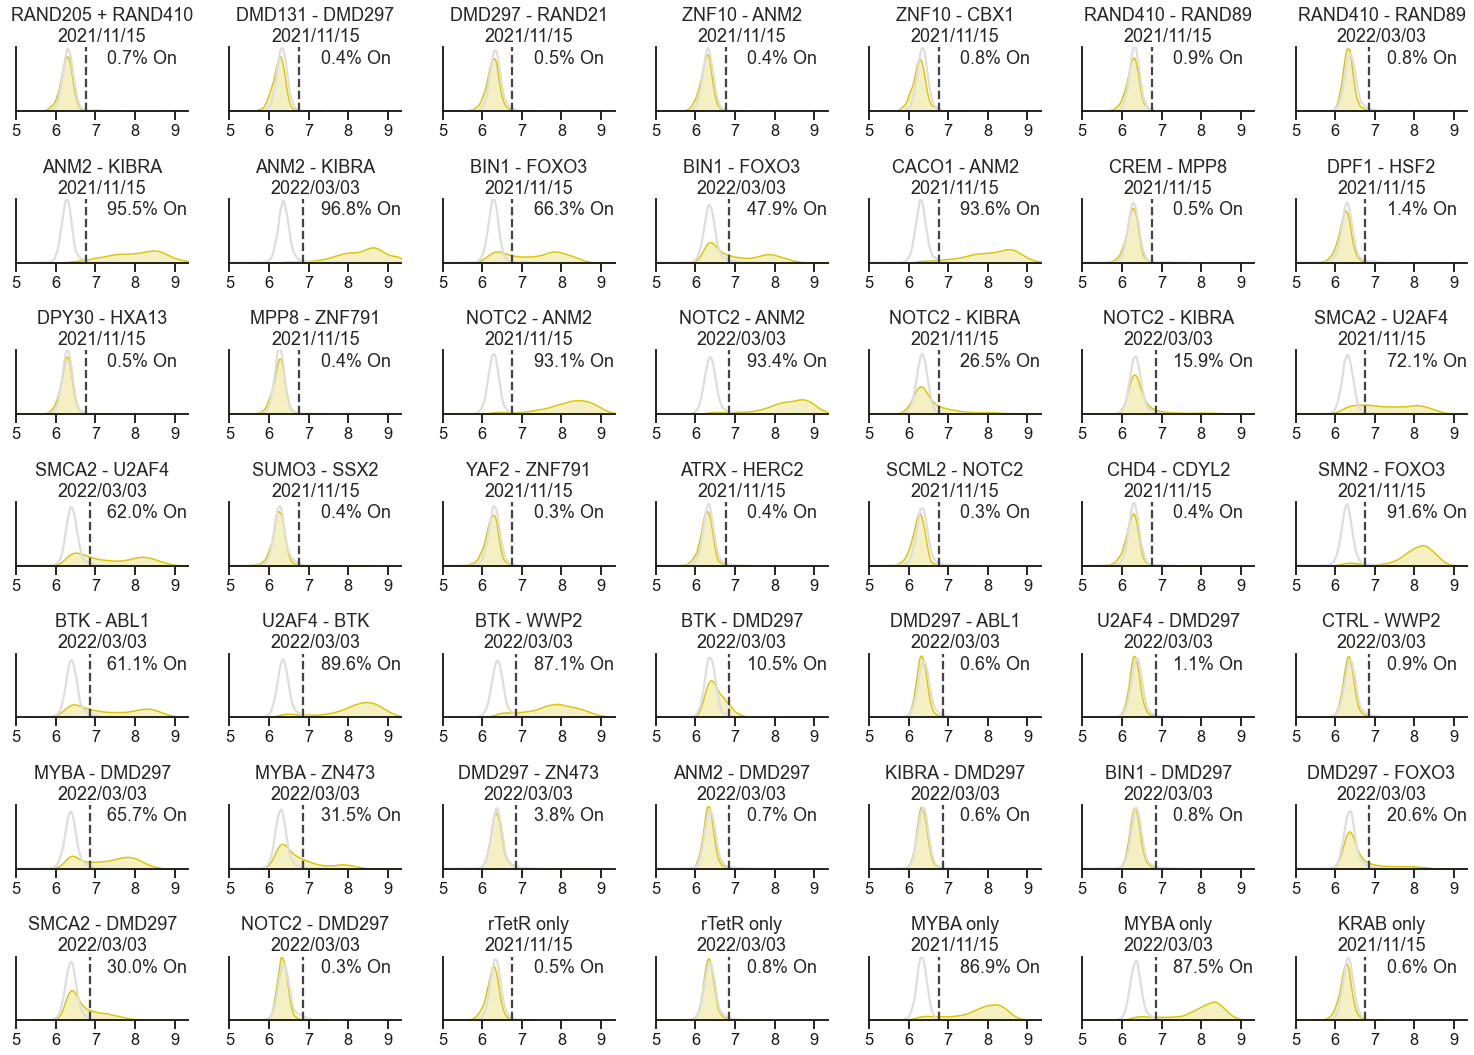

In [12]:
fig, axes = plt.subplots(7, 7, figsize=(21, 15))

for i, pair in tqdm(enumerate(pairings), total=len(pairings)):
    p, d = pair
    qd = df[(df["plasmid"] == p) & (df["date"] == d)]
    ax = axes[i // 7][i % 7]
    sns.kdeplot(
        data=qd[qd["day"] == 0],
        x="mCitrine-A",
        hue="day",
        palette=["#DEDEDE"],
        log_scale=True,
        legend=False,
        common_norm=False,
        fill=False,
        ax=ax,
    )
    sns.kdeplot(
        data=qd[qd["day"] == 2],
        x="mCitrine-A",
        hue="day",
        palette=["#DBC60D"],
        log_scale=True,
        legend=False,
        common_norm=False,
        fill=True,
        ax=ax,
    )
    ax.set_title(plasmid_dict[p] + "\n" + d)

    ax.axvline(get_citrine_threshold(2, d), color="#444444", linestyle="--")

    ax.set_xlim([1e5, 2.2e9])
    ax.set_xticks([1e5, 1e6, 1e7, 1e8, 1e9])
    ax.set_xticklabels([5, 6, 7, 8, 9])
    ax.set_ylim([0, 3])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    f_on = np.nanmean(list(qd[qd["day"] == 2]["Citrine On"]))
    ax.text(2e7, 2.25, "{:.1f}".format(f_on * 100) + "% On")

sns.despine()
plt.tight_layout()

fig.savefig("./all_activation_histograms.pdf", bbox_inches="tight")

# Comparing to screen data

In [13]:
screen_data = pd.read_csv("../../fig_1/04_scatter/pairs_baselined.csv")
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_sd_d2,d2_avg_d5,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,0.417810,2.079784,2.054285,0.493242,Repressor,Non-hit,A-N,Other,True,False
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,0.647041,0.255465,0.351655,0.582309,Repressor,Activator,A-A,Activator,True,True
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,0.485525,-0.846324,-0.808308,0.670493,Repressor,Repressor,R-R,Repressor,False,True
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,0.663824,0.466292,0.745666,0.626952,Activator,Activator,A-A,Activator,True,True
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,0.405776,1.728992,1.827117,0.364559,Repressor,Non-hit,R-N,Other,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.369082,-2.427493,-2.449007,0.414017,Repressor,Repressor,C-R,Repressor,NaN,NaN
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.688257,-2.736312,-2.750528,0.642879,Repressor,Repressor,C-R,Repressor,NaN,NaN
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.688257,-2.736312,-2.750528,0.642879,Repressor,Repressor,C-R,Repressor,NaN,NaN
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.667305,2.282155,2.281728,0.818380,Activator,Non-hit,C-N,Other,NaN,NaN


In [14]:
oligos = pd.read_csv(
    "../../fig_1/01_raw_counts/csvs/base_oligo_library.csv"
)


def domain_from_gene(g):
    if g == "Ctrl" or g == "CTRL":
        return "DMD_control_tiles;ENSG00000198947;;297;"
    else:
        of = oligos[oligos["Gene"] == g]
        assert len(list(of["label"])) == 1
        return list(of["label"])[0]


def get_domains(plasmid, description):
    if plasmid == 75:
        return ["DMD_control_tiles;ENSG00000198947;;297;", "Random_control;;;21;"]
    elif plasmid == 74:
        return [
            "DMD_control_tiles;ENSG00000198947;;131;",
            "DMD_control_tiles;ENSG00000198947;;297;",
        ]
    elif plasmid == 78:
        return ["Random_control;;;205;", "Random_control;;;410;"]
    # find the domain for each of the elements
    if " - " not in description:
        print(plasmid, description)
    d1, d2 = description.split(" - ")
    return [domain_from_gene(d1), domain_from_gene(d2)]

In [15]:
cdf = gdf[(gdf["plasmid"] < 1000) & (gdf["plasmid"] > 73)]
pairs = [
    get_domains(p, d) for p, d in zip(list(cdf["plasmid"]), list(cdf["description"]))
]
cdf["domain1"] = [p[0] for p in pairs]
cdf["domain2"] = [p[1] for p in pairs]
cdf["pair"] = [p[0] + " --- " + p[1] for p in pairs]
cdf

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_27035/17747253.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_27035/17747253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_27035/17747253.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,date,day,plasmid,description,replicate,index,FSC 488/10-A,SSC 488/10-A,mCherry-A,mCitrine-A,P1,mCherry,Citrine On,domain1,domain2,pair
2,2021/11/15,0.0,74,DMD - DMD,1.0,1.465569e+06,7.487829e+08,2.624635e+08,2.359572e+08,2.248402e+06,1.0,1.0,0.000291,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,DMD_control_tiles;ENSG00000198947;;131; --- DM...
3,2021/11/15,0.0,74,DMD - DMD,2.0,1.477666e+06,7.607374e+08,2.537070e+08,2.751042e+08,2.204398e+06,1.0,1.0,0.000781,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,DMD_control_tiles;ENSG00000198947;;131; --- DM...
4,2021/11/15,0.0,75,DMD - RANDCTRL,1.0,1.488782e+06,7.384105e+08,2.483225e+08,1.839675e+08,2.369572e+06,1.0,1.0,0.001901,DMD_control_tiles;ENSG00000198947;;297;,Random_control;;;21;,DMD_control_tiles;ENSG00000198947;;297; --- Ra...
5,2021/11/15,0.0,75,DMD - RANDCTRL,2.0,1.499342e+06,7.646983e+08,2.355111e+08,2.234286e+08,2.299056e+06,1.0,1.0,0.001482,DMD_control_tiles;ENSG00000198947;;297;,Random_control;;;21;,DMD_control_tiles;ENSG00000198947;;297; --- Ra...
6,2021/11/15,0.0,76,ZNF10 - ANM2,1.0,1.510455e+06,7.031778e+08,2.458344e+08,1.766295e+08,2.247289e+06,1.0,1.0,0.001756,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Human_KRAB_variant;P21506;146 --- Short_nuclea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,2022/03/03,2.0,142,Ctrl - FOXO3,2.0,1.347522e+06,6.638102e+08,2.003824e+08,2.409155e+08,1.532020e+07,1.0,1.0,0.199641,DMD_control_tiles;ENSG00000198947;;297;,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,DMD_control_tiles;ENSG00000198947;;297; --- Sh...
285,2022/03/03,2.0,144,SMCA2 - Ctrl,1.0,1.370633e+06,7.175981e+08,2.092163e+08,2.916326e+08,1.009483e+07,1.0,1.0,0.301277,Short_nuclear_domain;SMCA2_HUMAN;QLQ;150;34,DMD_control_tiles;ENSG00000198947;;297;,Short_nuclear_domain;SMCA2_HUMAN;QLQ;150;34 --...
286,2022/03/03,2.0,144,SMCA2 - Ctrl,2.0,1.377327e+06,6.871530e+08,2.103742e+08,3.875287e+08,9.497108e+06,1.0,1.0,0.285433,Short_nuclear_domain;SMCA2_HUMAN;QLQ;150;34,DMD_control_tiles;ENSG00000198947;;297;,Short_nuclear_domain;SMCA2_HUMAN;QLQ;150;34 --...
287,2022/03/03,2.0,157,NOTC2 - Ctrl,1.0,1.672071e+06,6.646618e+08,2.014605e+08,3.077314e+08,2.281055e+06,1.0,1.0,0.005508,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34,DMD_control_tiles;ENSG00000198947;;297;,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34...


In [16]:
jdf = (
    cdf.set_index("pair")
    .join(screen_data.set_index("pair"), how="left", rsuffix="_screen")
    .reset_index()
)
jdf

,pair,date,day,plasmid,description,replicate,index,FSC 488/10-A,SSC 488/10-A,mCherry-A,...,d2_sd_d2,d2_avg_d5,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit
0,DMD_control_tiles;ENSG00000198947;;131; --- DM...,2021/11/15,0.0,74,DMD - DMD,1.0,1.465569e+06,7.487829e+08,2.624635e+08,2.359572e+08,...,NaN,NaN,NaN,NaN,Control,Control,C-C,Control,False,False
1,DMD_control_tiles;ENSG00000198947;;131; --- DM...,2021/11/15,0.0,74,DMD - DMD,2.0,1.477666e+06,7.607374e+08,2.537070e+08,2.751042e+08,...,NaN,NaN,NaN,NaN,Control,Control,C-C,Control,False,False
2,DMD_control_tiles;ENSG00000198947;;131; --- DM...,2021/11/15,1.0,74,DMD - DMD,1.0,2.366335e+06,7.839800e+08,2.489975e+08,2.680065e+08,...,NaN,NaN,NaN,NaN,Control,Control,C-C,Control,False,False
3,DMD_control_tiles;ENSG00000198947;;131; --- DM...,2021/11/15,1.0,74,DMD - DMD,2.0,2.367482e+06,8.070144e+08,2.714072e+08,3.250887e+08,...,NaN,NaN,NaN,NaN,Control,Control,C-C,Control,False,False
4,DMD_control_tiles;ENSG00000198947;;131; --- DM...,2021/11/15,2.0,74,DMD - DMD,1.0,2.909420e+06,7.770143e+08,2.087345e+08,2.486945e+08,...,NaN,NaN,NaN,NaN,Control,Control,C-C,Control,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,Silencer_tiles;ENSG00000205571;13 --- Short_nu...,2021/11/15,0.0,99,SMN2 - FOXO3,1.0,1.914016e+06,7.161402e+08,2.614909e+08,2.013381e+08,...,0.981042,-0.055876,0.111979,0.639032,Activator,Activator,N-A,Other,True,False
253,Silencer_tiles;ENSG00000205571;13 --- Short_nu...,2021/11/15,0.0,99,SMN2 - FOXO3,2.0,1.930222e+06,7.319291e+08,2.824131e+08,3.263268e+08,...,0.981042,-0.055876,0.111979,0.639032,Activator,Activator,N-A,Other,True,False
254,Silencer_tiles;ENSG00000205571;13 --- Short_nu...,2021/11/15,1.0,99,SMN2 - FOXO3,1.0,2.433950e+06,7.724516e+08,2.330935e+08,2.076036e+08,...,0.981042,-0.055876,0.111979,0.639032,Activator,Activator,N-A,Other,True,False
255,Silencer_tiles;ENSG00000205571;13 --- Short_nu...,2021/11/15,2.0,99,SMN2 - FOXO3,1.0,3.081889e+06,7.229645e+08,1.976542e+08,1.797021e+08,...,0.981042,-0.055876,0.111979,0.639032,Activator,Activator,N-A,Other,True,False


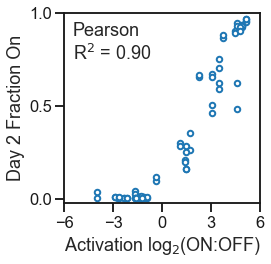

In [17]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

cordf = jdf[jdf["day"] == 2]

sns.scatterplot(
    data=cordf,
    x="avg_enrichment_d2",
    y="Citrine On",
    edgecolor="tab:blue",
    linewidth = 2,
    color="white",
    s = 30,
    ax=ax,
)

ax.set_xlim(-6, 6)
ax.set_xticks([-6, -3, 0, 3, 6])
ax.set_ylim(-0.025, 1)
ax.set_yticks([0, 0.5, 1])

xdf = cordf.dropna(subset=["avg_enrichment_d2", "Citrine On"])
r, p = st.pearsonr(xdf["avg_enrichment_d2"], xdf["Citrine On"])
ax.text(-5.5, 0.75, "Pearson\nR$^2$ = {:.2f}".format(r**2))


ax.set_xlabel("Activation log$_2$(ON:OFF)")
ax.set_ylabel("Day 2 Fraction On")

fig.savefig("./activator_correlation.pdf", bbox_inches="tight")

# MFI vs Fraction On

  0%|          | 0/49 [00:00<?, ?it/s]

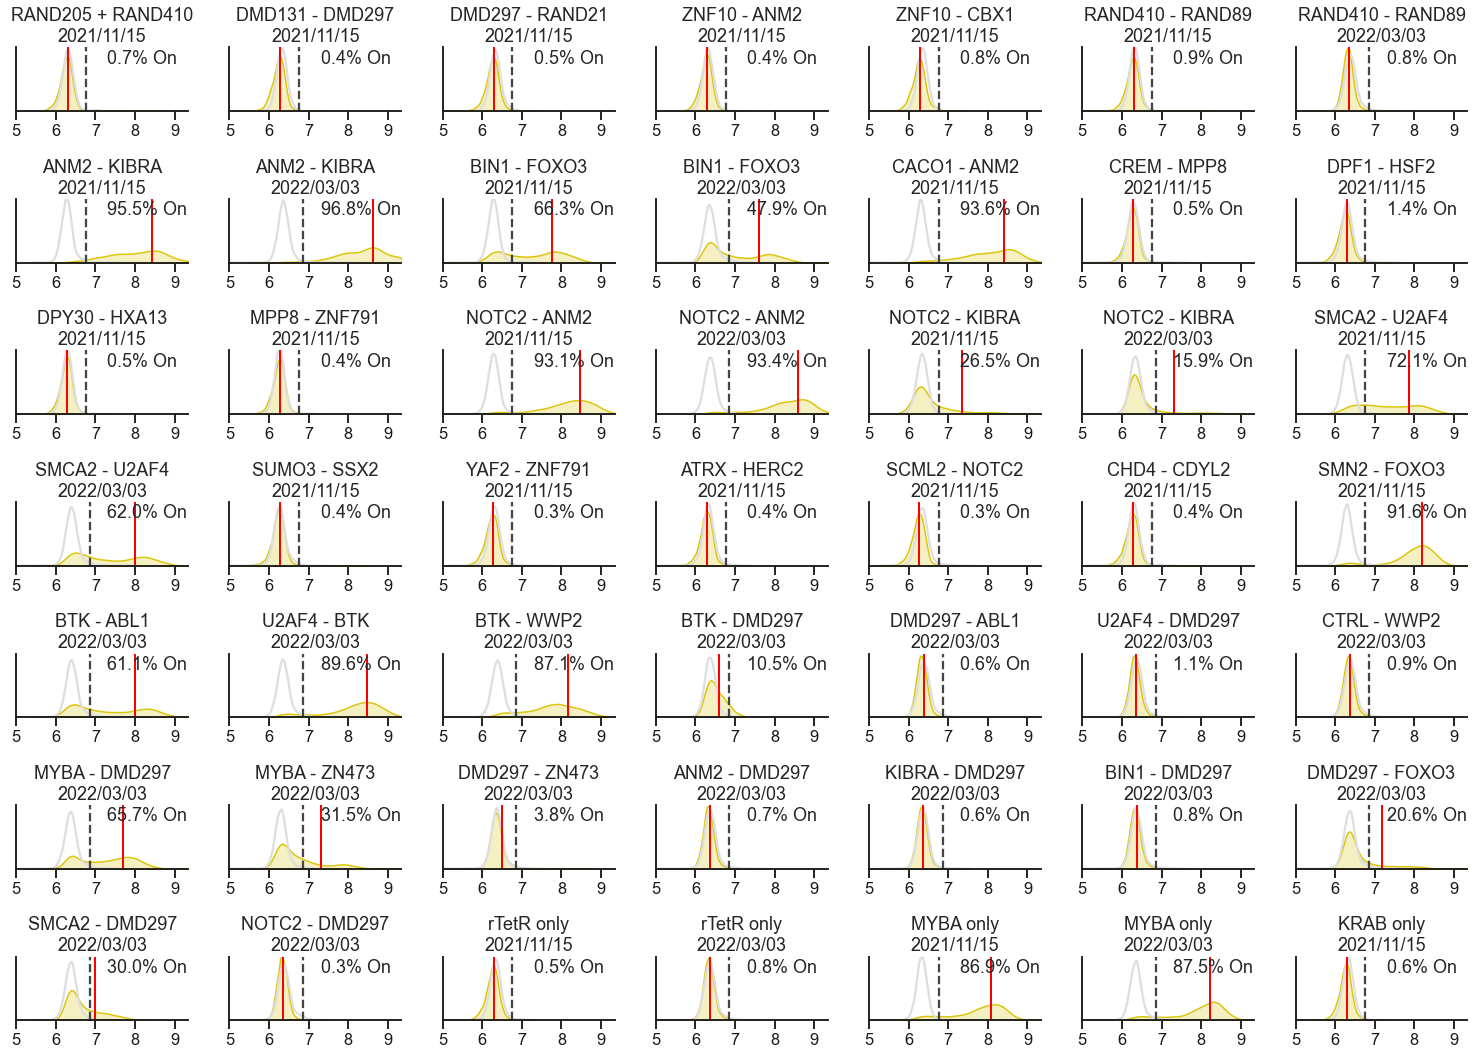

In [18]:
fig, axes = plt.subplots(7, 7, figsize=(21, 15))

mfi_dfs = []

for i, pair in tqdm(enumerate(pairings), total=len(pairings)):
    p, d = pair
    qd = df[(df["plasmid"] == p) & (df["date"] == d)]
    ax = axes[i // 7][i % 7]
    sns.kdeplot(
        data=qd[qd["day"] == 0],
        x="mCitrine-A",
        hue="day",
        palette=["#DEDEDE"],
        log_scale=True,
        legend=False,
        common_norm=False,
        fill=False,
        ax=ax,
    )
    sns.kdeplot(
        data=qd[qd["day"] == 2],
        x="mCitrine-A",
        hue="day",
        palette=["#DBC60D"],
        log_scale=True,
        legend=False,
        common_norm=False,
        fill=True,
        ax=ax,
    )
    ax.set_title(plasmid_dict[p] + "\n" + d)

    ax.axvline(get_citrine_threshold(2, d), color="#444444", linestyle="--")

    # compute MFI
    datums = np.array(qd[qd["day"] == 2]["mCitrine-A"]).reshape(-1, 1)
    dat_mean = np.power(10, np.mean(np.log10(datums)))
    gm1 = GaussianMixture(n_components=1).fit(datums)
    gm2 = GaussianMixture(n_components=2).fit(datums)
    gm3 = GaussianMixture(n_components=3).fit(datums)
    gmx = gm1 if gm1.aic(datums) > gm2.aic(datums) else gm2
    gmx = gmx if gmx.aic(datums) > gm3.aic(datums) else gm3
    means = gmx.means_
    weights = gmx.weights_
    gmeans = [means[i] for i in range(len(means)) if weights[i] > 0.1]
    mfi_max = np.max(gmeans)
    mfi_min = np.min(gmeans)
    mfi_key = (
        mfi_max if np.abs(dat_mean - mfi_max) < np.abs(dat_mean - mfi_min) else mfi_min
    )
    ax.axvline(x=mfi_key, linestyle="-", color="red", lw=2)

    ax.set_xlim([1e5, 2.2e9])
    ax.set_xticks([1e5, 1e6, 1e7, 1e8, 1e9])
    ax.set_xticklabels([5, 6, 7, 8, 9])
    ax.set_ylim([0, 3])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    f_on = np.nanmean(list(qd[qd["day"] == 2]["Citrine On"]))
    ax.text(2e7, 2.25, "{:.1f}".format(f_on * 100) + "% On")

    mfi_dfs.append(
        pd.DataFrame.from_dict(
            {"plasmid": [p], "date": [d], "f_on": [f_on], "mfi": [mfi_key]}
        )
    )

sns.despine()
plt.tight_layout()

mfi_df = pd.concat(mfi_dfs)

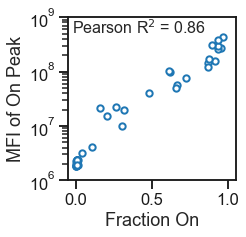

In [19]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=mfi_df,
    x="f_on",
    y="mfi",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
)

ax.set_yscale("log")
ax.set_ylim(1e6, 1e9)
ax.set_yticks([1e6, 1e7, 1e8, 1e9])
ax.set_xlim(-0.05, 1.05)
ax.set_xticks([0, 0.5, 1])

ax.set_xlabel("Fraction On")
ax.set_ylabel("MFI of On Peak")

r, p = st.pearsonr(mfi_df["f_on"], mfi_df["mfi"])
ax.text(x=-0.025, y=4.9e8, s="Pearson R$^2$ = {:.2f}".format(r), fontsize=16)

fig.savefig("./mfi_fon_correlation.pdf", bbox_inches="tight")

In [20]:
mfi_df.to_csv("./data/mfi_data.csv", index=False)